<a href="https://colab.research.google.com/github/ssddatascience/The-Quora-Question-Pair-Similarity-Analysis/blob/main/QuoraQuestionPairsAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Quora is a platform for Q&A, just like StackOverflow. But quora is more of a general-purpose Q&A platform that means there is not much code like in StackOverflow.

One of the many problems that quora face is the duplication of questions. Duplication of question ruins the experience for both the questioner and the answerer. Since the questioner is asking a duplicate question, we can just show him/her the answers to the previous question. And the answerer doesn't have to repeat his/her answer for essentially the same questions.

For example, we have a question like "How can I be a good geologist?" and there are some answers to that question. Later someone else asks another question like "What should I do to be a great geologist?".
We can see that both the questions are asking the same thing. Even though the wordings for the question are different, the intention of both questions is same. 

So the answers will be same for both questions. That means we can just show the answers of the first question. That way the person who is asking the question will get the answers immediately and people who have answered already the first question don't have to repeat themselves.

# **Business Objectives and Constraints**

There is no strict latency requirement.

We would like to have interpretability but it is not absolutely mandatory.

The cost of misclassification is medium.

Both classes (duplicate or not) are equally important.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.3/224.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import RandomOverSamplers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import nltk
import time
from matplotlib.pyplot import figure
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
import gc
from sklearn.model_selection import cross_val_score
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pip install sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imblearn.over_sampling import RandomOverSampler




In [ ]:
pip install -U fuzzywuzzy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('train.csv')

In [ ]:
print(data.columns)
print(data.is_duplicate.unique())
print(data.is_duplicate.value_counts())
print(data.shape)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')
[0 1]
0    255027
1    149263
Name: is_duplicate, dtype: int64
(404290, 6)


Available Columns : id, qid1, qid2, question1, question2, is_duplicate

Class labels : 0, 1

Total training data / No. of rows : 404290

No. of columns : 6

is_duplicate is the dependent variable.

No. of non-duplicate data points is 255027

No. of duplicate data points is 149263

We have 404290 training data points. And only 36.92% are positive. That means it is an imbalanced dataset.

# **Business Metrics**

It is a binary classification.

We need to minimize the log loss for this challenge.

# Basic **EDA**

In [ ]:
import pandas as pd
testdata = pd.read_csv('test.csv')
#testdata = pd.read_csv('test.csv') 



#print(testdata.shape)


In [ ]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
testdata.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [ ]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054162 entries, 0 to 1054161
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   test_id    1054162 non-null  int64 
 1   question1  1054161 non-null  object
 2   question2  1054158 non-null  object
dtypes: int64(1), object(2)
memory usage: 24.1+ MB


Test data** don't have question ids. So the independent variables are **question1, question2 **bold text**and the dependent variable is is_duplicate.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
data = data.dropna()
print(data.shape)

(404287, 6)


In [ ]:
print(data.duplicated(('question1', 'question2')).sum())

0


In [ ]:
print(testdata.duplicated(('question1', 'question2')).sum())

1166


3 rows had null values. So We removed them and now We have 404287 question pairs.

0    0.630799
1    0.369201
Name: is_duplicate, dtype: float64


<Axes: title={'center': 'Distribution of classes'}>

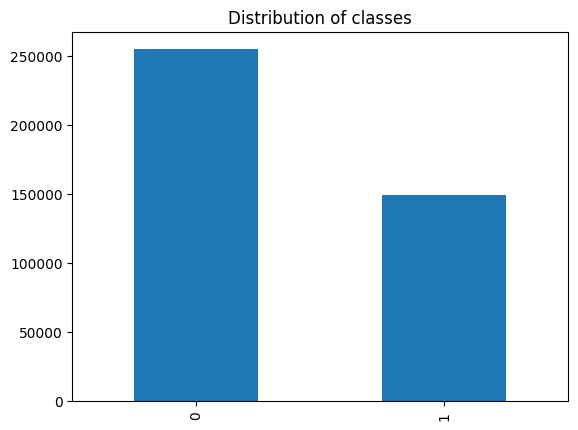

In [ ]:
duplicate_value_counts = data.is_duplicate.value_counts()
print(duplicate_value_counts/duplicate_value_counts.sum())
plt.title('Distribution of classes')
duplicate_value_counts.plot.bar()

36.92% of question pairs are duplicates and 63.08% of questions pair non-duplicate.

In [ ]:
qids = np.append(data.qid1.values,data.qid2.values)
print(len(set(qids)))
print(len(qids))

537929
808574


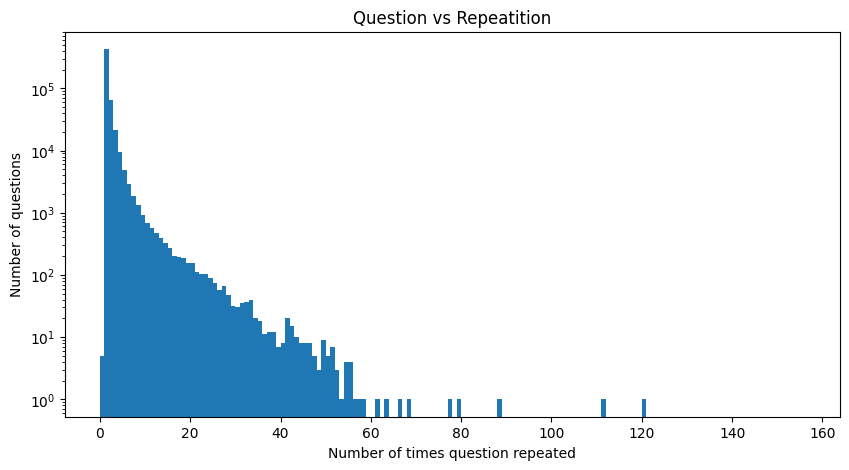

0 157


In [ ]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5)) 
plt.hist(occurences, bins=range(0,np.max(occurences)))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print(np.min(occurences), np.max(occurences))

Out of 808574 total questions (including both question1 and question2), 789795 are unique.

Most of the questions are repeated very few times. Only a few of them are repeated multiple times.

One question is repeated 48 times which is the max number of repetitions.

In [ ]:
print(data.question1.apply(len).min())
print(data.loc[data.question1.apply(len).argmin()])
print(data.question2.apply(len).min())
print(data.loc[data.question2.apply(len).argmin()])

1
id                                                           3306
qid1                                                         6553
qid2                                                         6554
question1                                                       .
question2       Why is Cornell's endowment the lowest in the I...
is_duplicate                                                    0
Name: 3306, dtype: object
1
id                                                          47056
qid1                                                        84067
qid2                                                        84068
question1       Is there anywhere in the world offering pain m...
question2                                                       ?
is_duplicate                                                    0
Name: 47056, dtype: object


There are some questions with very few characters, which does not make sense. It will be taken care of later with Data Cleaning.

# **Data Cleaning**

In [ ]:
def preprocess_text(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"http\S+", "", x)
    x = re.sub('\W', ' ', x)
    
    lemmatizer = WordNetLemmatizer()
    x = lemmatizer.lemmatize(x)
    bfs = BeautifulSoup(x)
    x = bfs.get_text()
    x = x.strip()
    return x

In [ ]:
def data_cleaning(data):
    newdata = pd.DataFrame()
    newdata['question1_final'] = data.question1.apply(preprocess_text)
    newdata['question2_final'] = data.question2.apply(preprocess_text)
    return newdata

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
traindata = data_cleaning(data)

In [ ]:
#testdata.head()



testdata = data_cleaning(testdata)

In [ ]:
print(data.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [ ]:
print(traindata.head())

                                     question1_final  \
0  what is the step by step guide to invest in sh...   
1  what is the story of kohinoor  koh i noor  dia...   
2  how can i increase the speed of my internet co...   
3  why am i mentally very lonely  how can i solve it   
4  which one dissolve in water quikly sugar  salt...   

                                     question2_final  
0  what is the step by step guide to invest in sh...  
1  what would happen if the indian government sto...  
2  how can internet speed be increased by hacking...  
3  find the remainder when  math 23  24   math  i...  
4             which fish would survive in salt water  


# Feature Extraction

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings
import gc
from sklearn.model_selection import cross_val_score
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pip install stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def doesMatch (q, match):
    q1, q2 = q['question1_final'], q['question2_final']
    q1 = q1.split()
    q2 = q2.split()
    if len(q1)>0 and len(q2)>0 and q1[match]==q2[match]:
        return 1
    else:
        return 0

In [ ]:
pip install stopwords

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def feature_extract(data):
    data['q1_char_num'] = data.question1_final.apply(len)
    data['q2_char_num'] = data.question2_final.apply(len)
    data['q1_word_num'] = data.question1_final.apply(lambda x: len(x.split()))
    data['q2_word_num'] = data.question2_final.apply(lambda x: len(x.split()))
    
    data['total_word_num'] = data['q1_word_num'] + data['q2_word_num']
    data['differ_word_num'] = abs(data['q1_word_num'] - data['q2_word_num'])
    data['same_first_word'] = data.apply(lambda x: doesMatch(x, 0) ,axis=1)
    data['same_last_word'] = data.apply(lambda x: doesMatch(x, -1) ,axis=1)
    data['total_unique_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split()))) ,axis=1)
    data['total_unique_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).union(set(x.question2_final.split())) -set(stopwords.words('english'))) ,axis=1)
    data['total_unique_word_num_ratio'] = data['total_unique_word_num'] / data['total_word_num']
    
    data['common_word_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split()))) ,axis=1)
    data['common_word_ratio'] = data['common_word_num'] / data['total_unique_word_num']
    data['common_word_ratio_min'] = data['common_word_num'] / data.apply(lambda x: min(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    data['common_word_ratio_max'] = data['common_word_num'] / data.apply(lambda x: max(len(set(x.question1_final.split())), len(set(x.question2_final.split()))) ,axis=1) 
    
    data['common_word_withoutstopword_num'] = data.apply(lambda x: len(set(x.question1_final.split()).intersection(set(x.question2_final.split())) - set(stopwords.words('english'))) ,axis=1)
    data['common_word_withoutstopword_ratio'] = data['common_word_withoutstopword_num'] / data['total_unique_word_withoutstopword_num']
    data['common_word_withoutstopword_ratio_min'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: min(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    data['common_word_withoutstopword_ratio_max'] = data['common_word_withoutstopword_num'] / data.apply(lambda x: max(len(set(x.question1_final.split()) - set(stopwords.words('english'))), len(set(x.question2_final.split()) - set(stopwords.words('english')))) ,axis=1) 
    
    data["fuzz_ratio"] = data.apply(lambda x: fuzz.ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_partial_ratio"] = data.apply(lambda x: fuzz.partial_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_set_ratio"] = data.apply(lambda x: fuzz.token_set_ratio(x.question1_final, x.question2_final), axis=1)
    data["fuzz_token_sort_ratio"] = data.apply(lambda x: fuzz.token_sort_ratio(x.question1_final, x.question2_final), axis=1)
    data.fillna(0, inplace=True)
    return data

FuzzyWuzzy uses Levenshtein Distance to calculate the differences between sequences. https://github.com/seatgeek/fuzzywuzzy

In [ ]:
traindata = feature_extract(traindata)

In [ ]:
testdata = feature_extract(testdata)

In [ ]:
traindata.head()

,question1_final,question2_final,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,...,common_word_ratio_min,common_word_ratio_max,common_word_withoutstopword_num,common_word_withoutstopword_ratio,common_word_withoutstopword_ratio_min,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,65,56,14,12,26,2,1,0,...,1.000000,0.916667,5,0.833333,1.0,0.833333,93,100,100,93
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,50,87,10,15,25,5,1,0,...,0.700000,0.500000,4,0.363636,0.8,0.400000,66,74,86,63
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,72,58,14,10,24,4,1,0,...,0.400000,0.285714,2,0.222222,0.4,0.333333,43,46,63,63
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math i...,49,64,11,13,24,2,0,0,...,0.000000,0.000000,0,0.000000,0.0,0.000000,9,11,28,24
4,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,75,38,13,7,20,6,1,0,...,0.571429,0.307692,2,0.153846,0.4,0.200000,35,55,67,47


In [ ]:
traindata.shape

(404287, 25)

EDA with Features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-73-a7db2cb3c1eb>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['total_word_num'],  palette="Dark2", ax=ax[0])


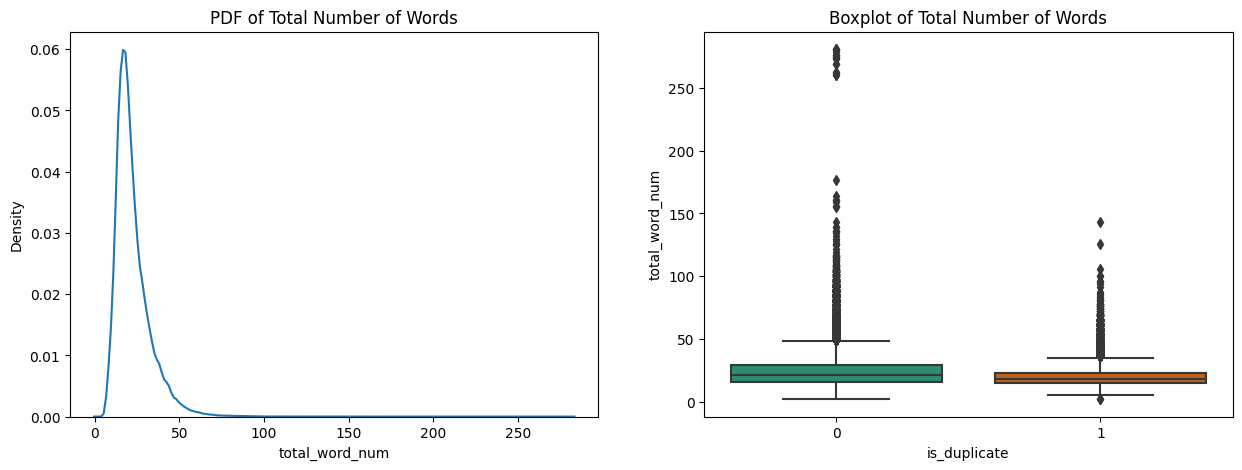

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Words')
sns.kdeplot(traindata['total_word_num'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Words')
sns.boxplot(x=data.is_duplicate, y=traindata['total_word_num'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-74-5e27b319168a>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['differ_word_num'],  palette="Dark2", ax=ax[0])


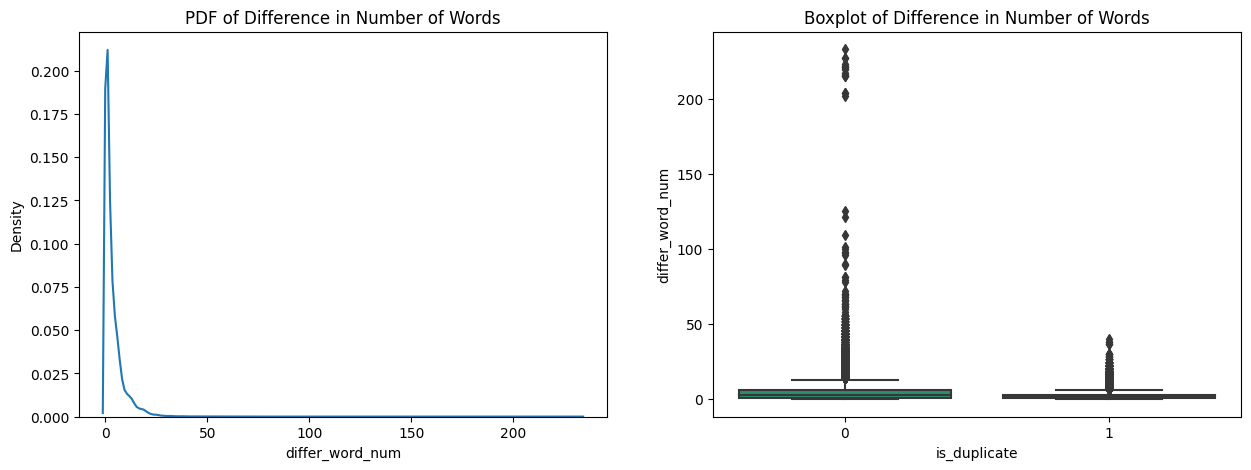

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Difference in Number of Words')
sns.kdeplot(traindata['differ_word_num'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Difference in Number of Words')
sns.boxplot(x=data.is_duplicate, y=traindata['differ_word_num'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-76-a879a6a006c3>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['same_first_word'], palette="Dark2", ax=ax[0])


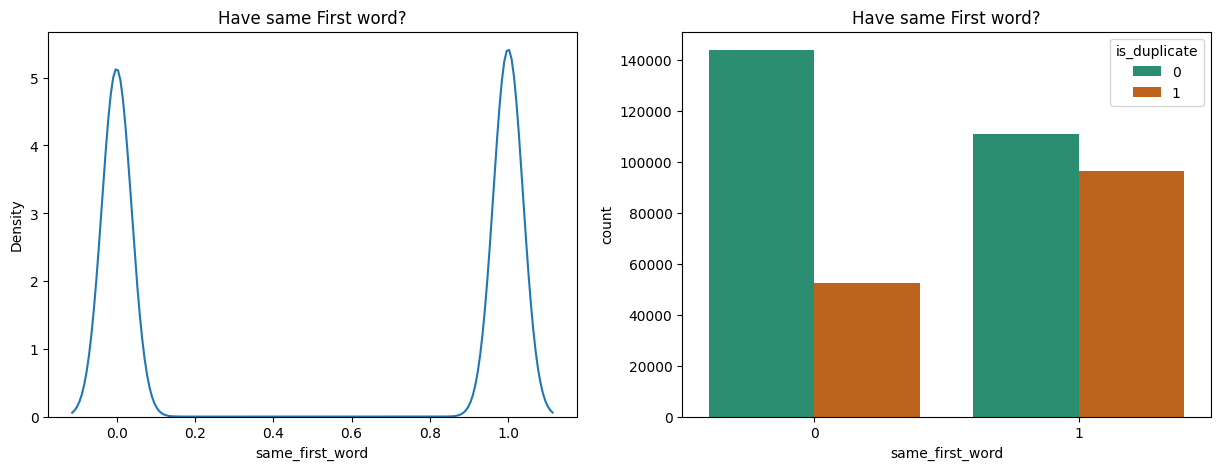

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same First word?')
sns.kdeplot(traindata['same_first_word'], palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same First word?')
sns.countplot(x=traindata['same_first_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-78-9d78e9822fb0>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['same_last_word'],  palette="Dark2", ax=ax[0])


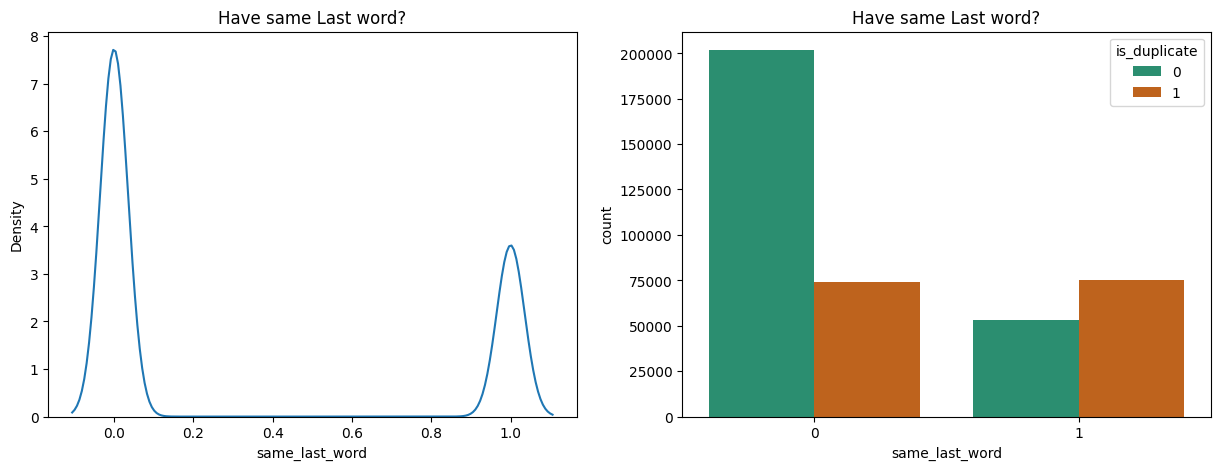

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Have same Last word?')
sns.kdeplot(traindata['same_last_word'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Have same Last word?')
sns.countplot(x=traindata['same_last_word'], hue=data.is_duplicate, palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-79-ed5e176d7965>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['total_unique_word_num'],  palette="Dark2", ax=ax[0])


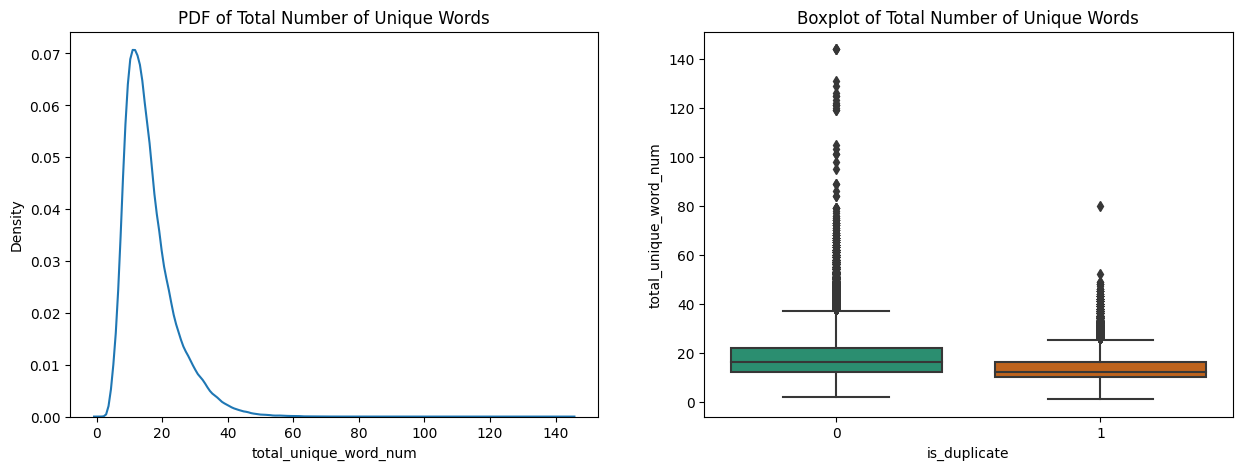

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Unique Words')
sns.kdeplot(traindata['total_unique_word_num'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Unique Words')
sns.boxplot(x=data.is_duplicate, y=traindata['total_unique_word_num'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-80-29d004379761>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['total_unique_word_withoutstopword_num'],  palette="Dark2", ax=ax[0])


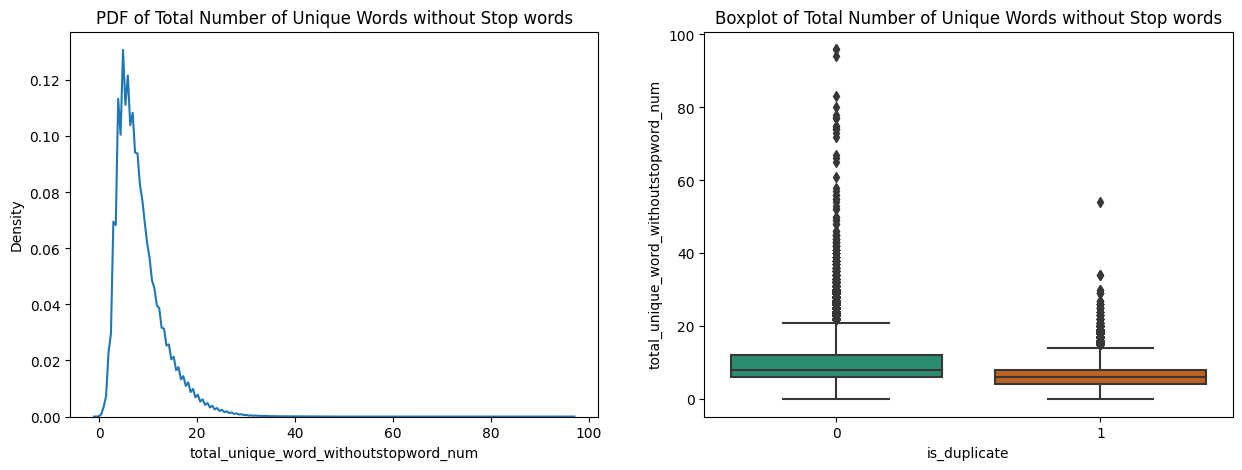

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Number of Unique Words without Stop words')
sns.kdeplot(traindata['total_unique_word_withoutstopword_num'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Number of Unique Words without Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['total_unique_word_withoutstopword_num'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-81-44d6b9cbf898>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['total_unique_word_num_ratio'],  palette="Dark2", ax=ax[0])


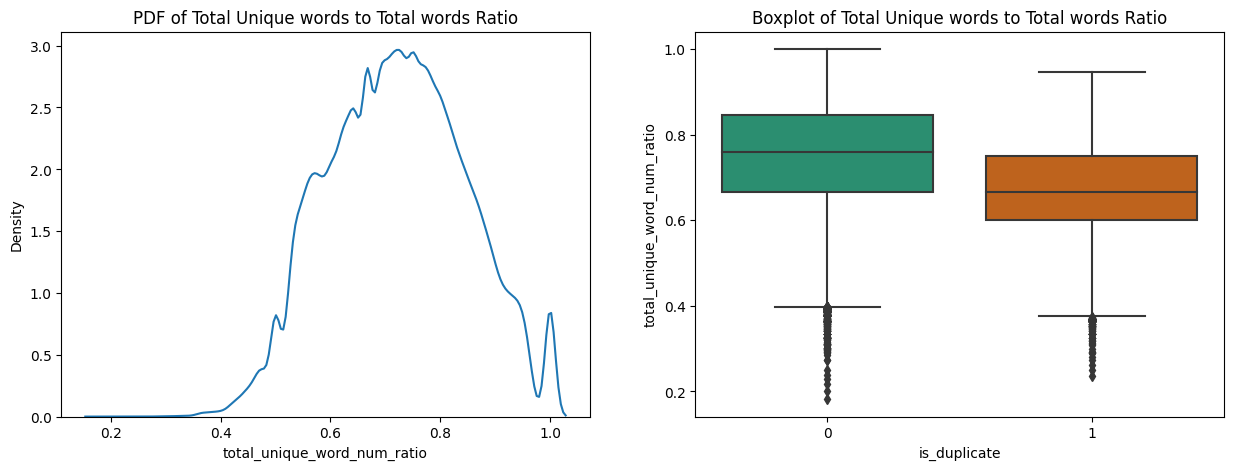

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Total Unique words to Total words Ratio')
sns.kdeplot(traindata['total_unique_word_num_ratio'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Total Unique words to Total words Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['total_unique_word_num_ratio'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-82-6d47c532026f>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_num'],  palette="Dark2", ax=ax[0])


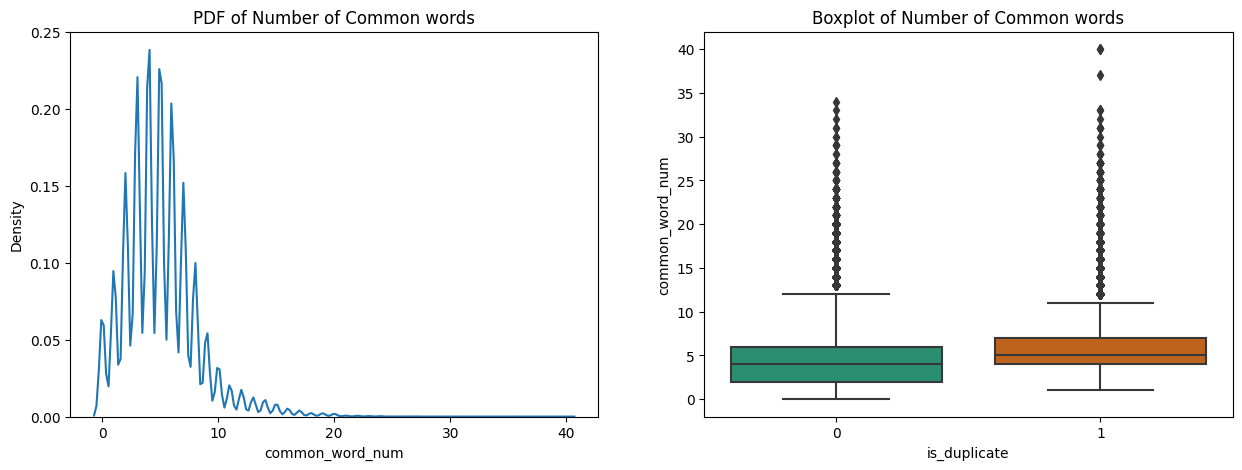

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Number of Common words')
sns.kdeplot(traindata['common_word_num'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Number of Common words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_num'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-83-2bc449be3dfe>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_ratio'],  palette="Dark2", ax=ax[0])


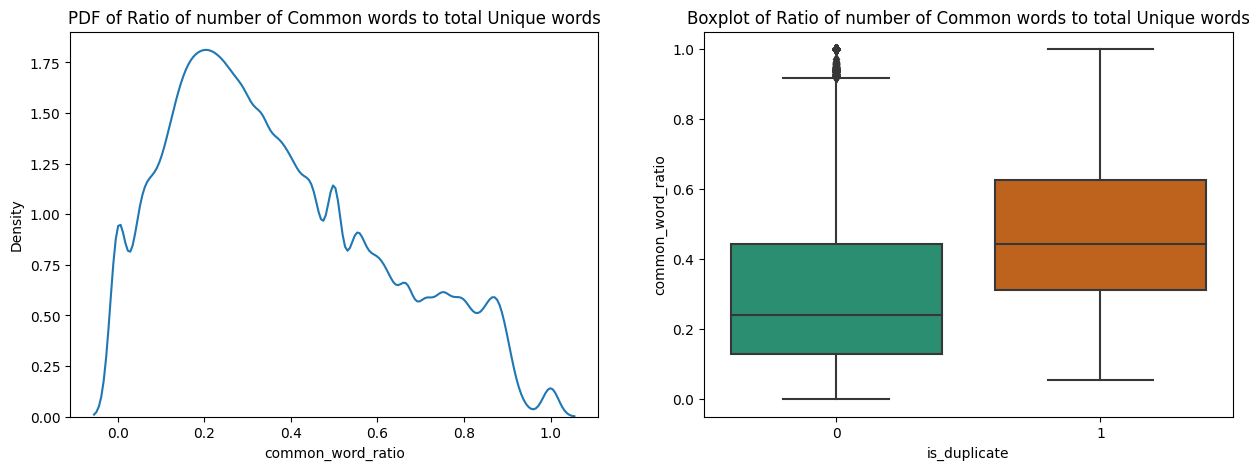

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to total Unique words')
sns.kdeplot(traindata['common_word_ratio'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to total Unique words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_ratio'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-84-b07245491e13>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_ratio_min'],  palette="Dark2", ax=ax[0])


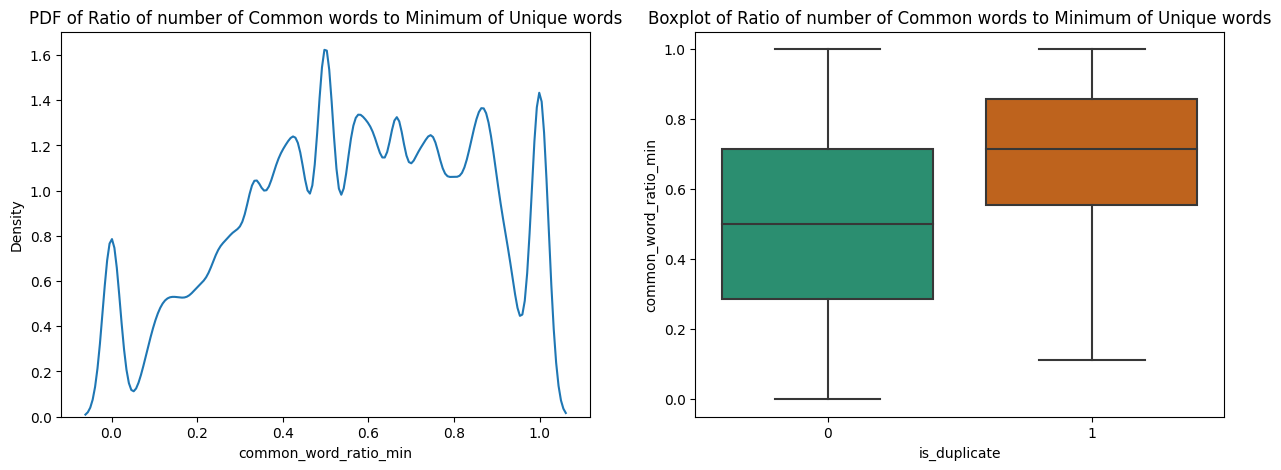

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to Minimum of Unique words')
sns.kdeplot(traindata['common_word_ratio_min'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to Minimum of Unique words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_ratio_min'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-85-e569aeb0c30a>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_ratio_max'],  palette="Dark2", ax=ax[0])


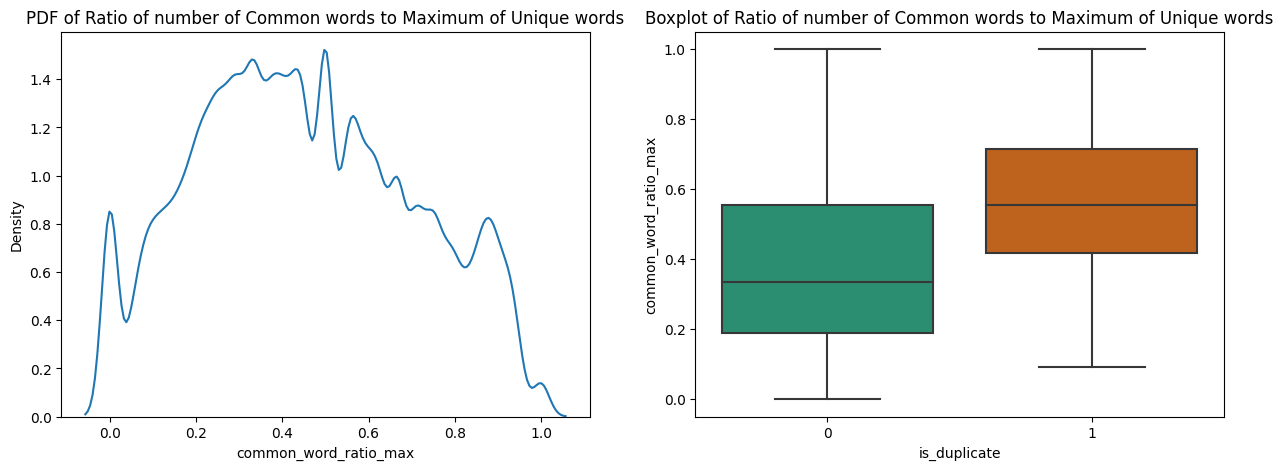

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Ratio of number of Common words to Maximum of Unique words')
sns.kdeplot(traindata['common_word_ratio_max'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Ratio of number of Common words to Maximum of Unique words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_ratio_max'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-87-56747b48e109>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_withoutstopword_num'], palette="Dark2", ax=ax[0])


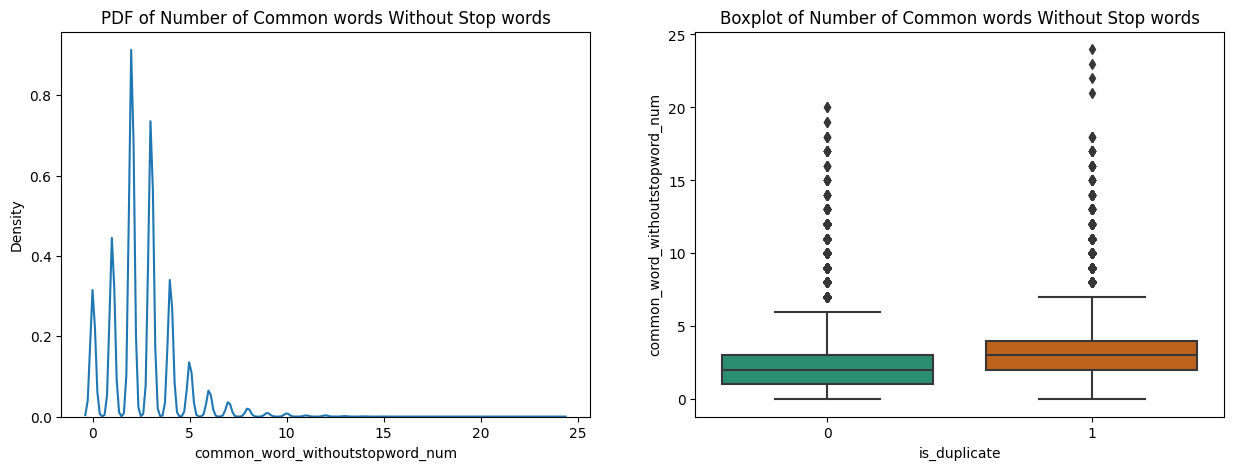

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Number of Common words Without Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_num'], palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Number of Common words Without Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_num'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-88-2d1e9af502d8>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_withoutstopword_ratio'],  palette="Dark2", ax=ax[0])


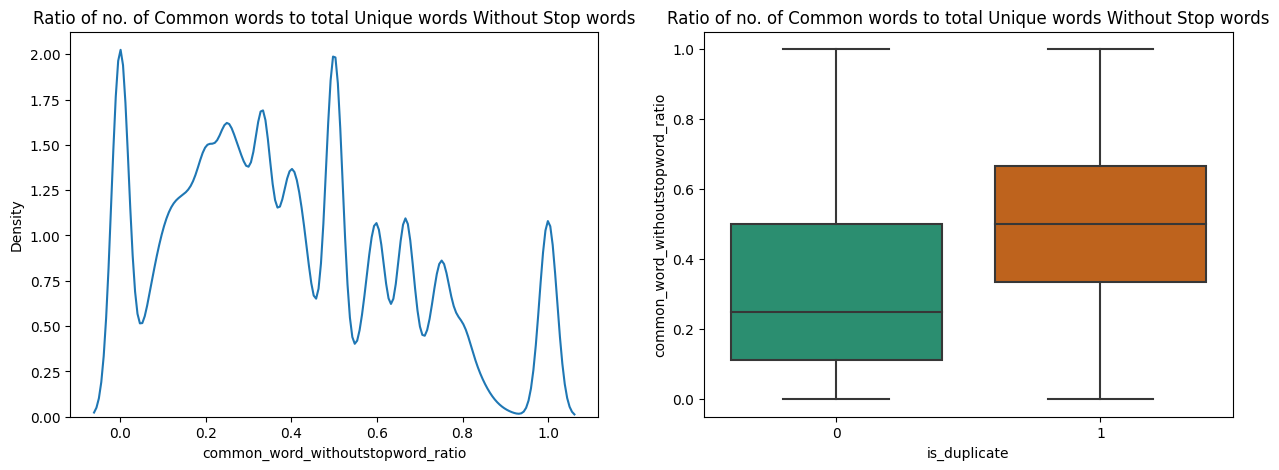

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to total Unique words Without Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_ratio'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to total Unique words Without Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_ratio'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-89-e6e1f1c36a0a>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_withoutstopword_ratio_min'],  palette="Dark2", ax=ax[0])


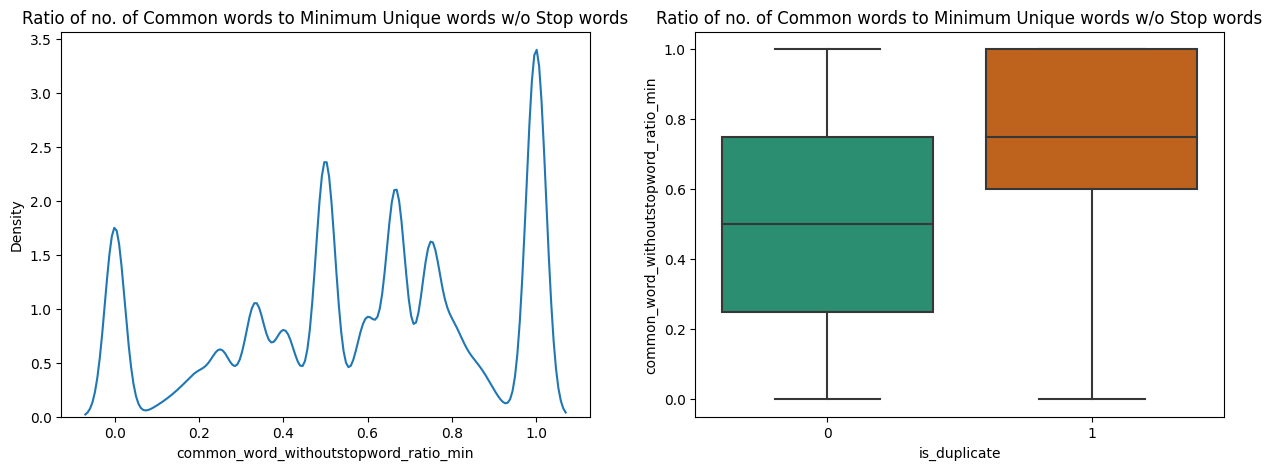

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to Minimum Unique words w/o Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_ratio_min'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to Minimum Unique words w/o Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_ratio_min'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-90-5a337a49e7fa>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['common_word_withoutstopword_ratio_max'],  palette="Dark2", ax=ax[0])


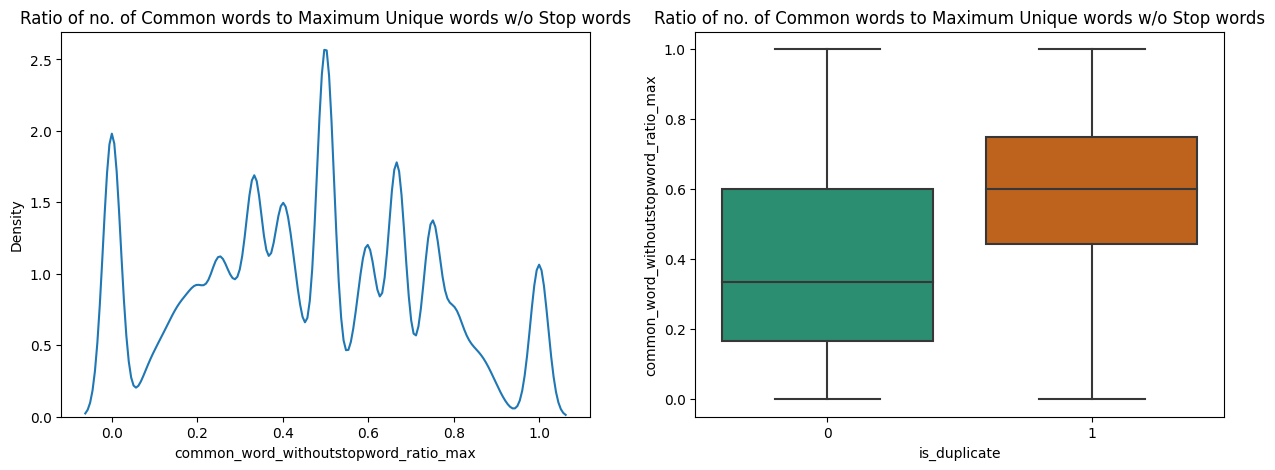

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Ratio of no. of Common words to Maximum Unique words w/o Stop words')
sns.kdeplot(traindata['common_word_withoutstopword_ratio_max'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Ratio of no. of Common words to Maximum Unique words w/o Stop words')
sns.boxplot(x=data.is_duplicate, y=traindata['common_word_withoutstopword_ratio_max'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-91-2b1c17d602ae>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['fuzz_ratio'],  palette="Dark2", ax=ax[0])


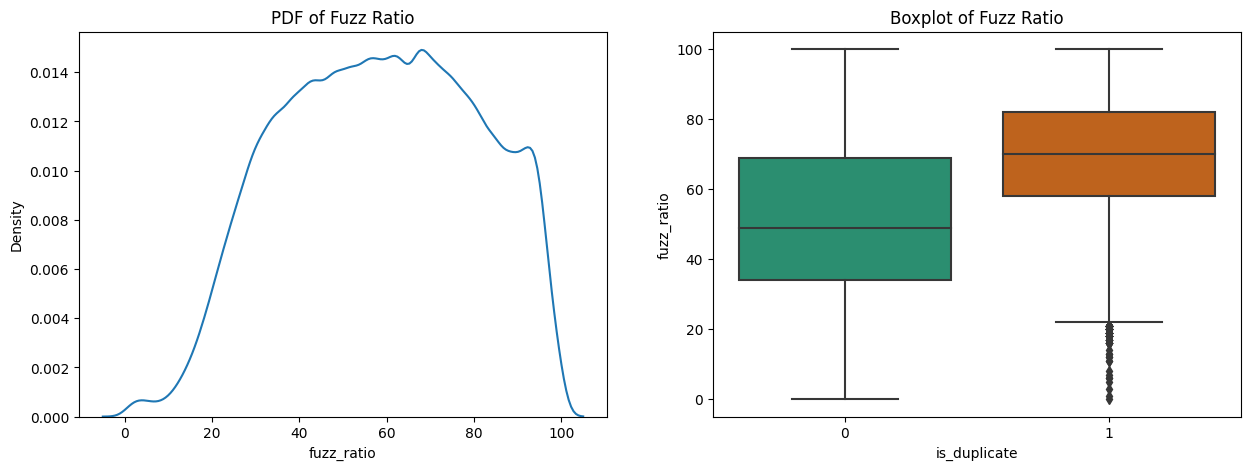

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Ratio')
sns.kdeplot(traindata['fuzz_ratio'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_ratio'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-92-d75295fde3de>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['fuzz_partial_ratio'],  palette="Dark2", ax=ax[0])


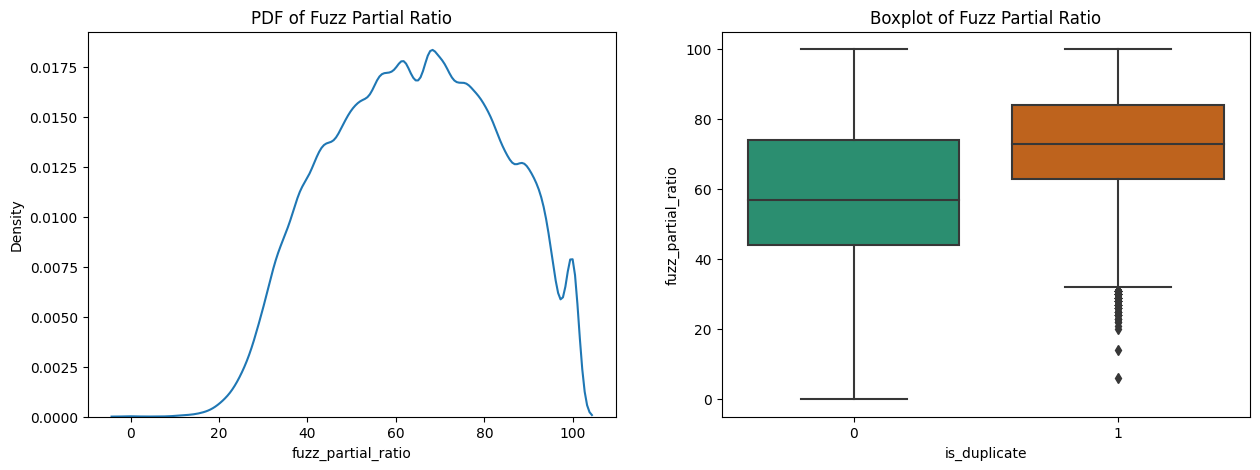

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Partial Ratio')
sns.kdeplot(traindata['fuzz_partial_ratio'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Partial Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_partial_ratio'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-93-8d680ba63629>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['fuzz_token_set_ratio'],  palette="Dark2", ax=ax[0])


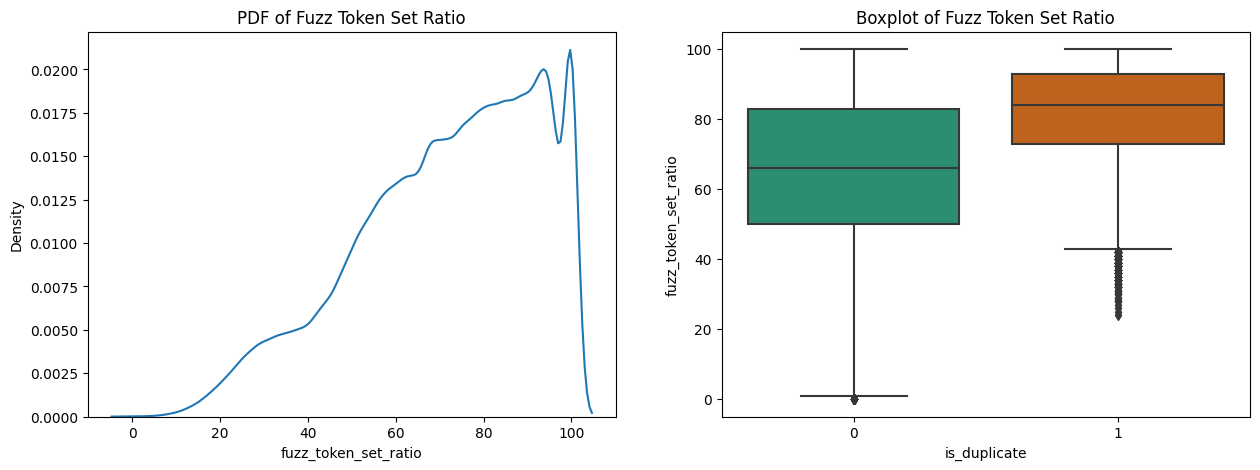

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Token Set Ratio')
sns.kdeplot(traindata['fuzz_token_set_ratio'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Token Set Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_token_set_ratio'], palette="Dark2", ax=ax[1])
plt.show()

<ipython-input-94-d3376c6c82be>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(traindata['fuzz_token_sort_ratio'],  palette="Dark2", ax=ax[0])


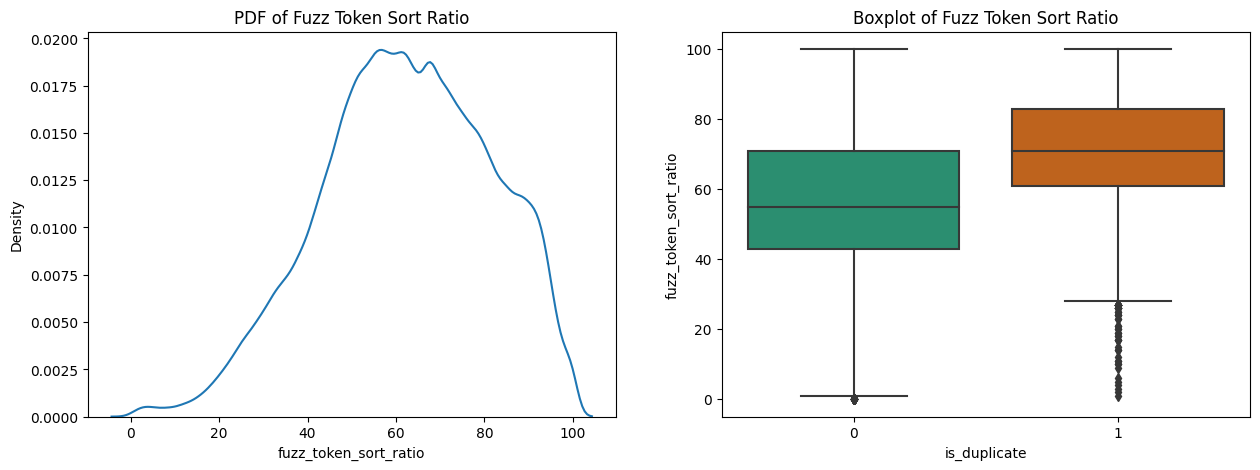

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('PDF of Fuzz Token Sort Ratio')
sns.kdeplot(traindata['fuzz_token_sort_ratio'],  palette="Dark2", ax=ax[0])
ax[1].title.set_text('Boxplot of Fuzz Token Sort Ratio')
sns.boxplot(x=data.is_duplicate, y=traindata['fuzz_token_sort_ratio'], palette="Dark2", ax=ax[1])
plt.show()

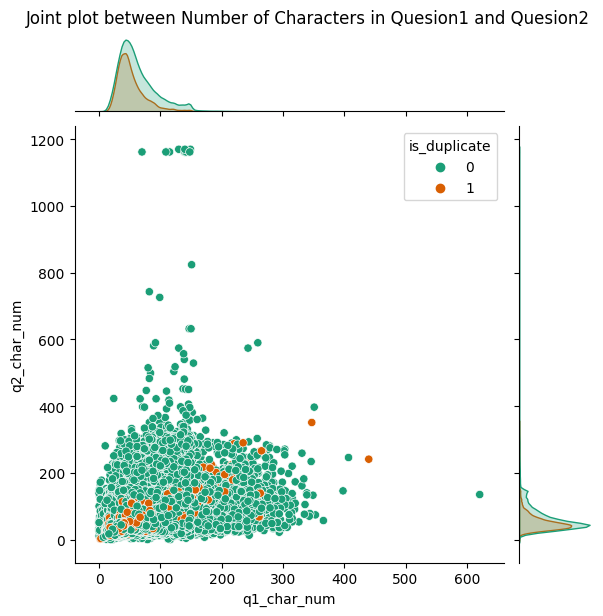

In [ ]:
g = sns.jointplot(x = 'q1_char_num', y = 'q2_char_num', kind = "scatter", hue=data.is_duplicate, data = traindata, palette="Dark2")
g.fig.suptitle("Joint plot between Number of Characters in Quesion1 and Quesion2", y=1.02)
plt.show()

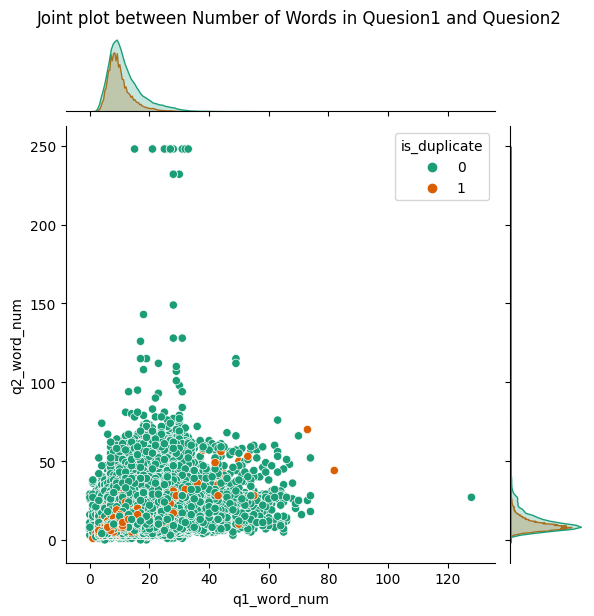

In [ ]:
g = sns.jointplot(x = 'q1_word_num', y = 'q2_word_num', kind = "scatter", hue=data.is_duplicate, data = traindata, palette="Dark2")
g.fig.suptitle("Joint plot between Number of Words in Quesion1 and Quesion2", y=1.02)
plt.show()

# Featurization with SentenceBERT
I tried InferSent sentence embeddings. But it returns 4096 dimension representation. And after applying it the train data became huge. So I discarded it. And I chose SentenceBERT for this problem.

SentenceBERT is a BERT based sentence embedding technique. We will use pre-trained SentenceBERT model paraphrase-mpnet-base-v2, which is recommended for best quality. The SentenceBERT produces an output of 768 dimensions. https://www.sbert.net/

In [ ]:
modelST = SentenceTransformer('paraphrase-mpnet-base-v2')

HfHubHTTPError: ignored

In [ ]:
# It took a lot of time, caused gpu overheat.
# So I decided to do it in batch and save them in file.
def getBertEmbeddings(data, filename):
    batch = 20000
    with open(filename, 'wb') as f:
        while(len(data)):
            tempdata = data[:batch]
            data = data[batch:]
            tempembed = modelST.encode(tempdata.values, device='cuda')
            np.save(f, tempembed, allow_pickle=True)
#             time.sleep(60) # for gpu heating issue

In [ ]:
# Get SentenceBERT embedding of train data
getBertEmbeddings(traindata.question1_final, 'temp_train_question1_sentenceBERT.npy')
getBertEmbeddings(traindata.question2_final, 'temp_train_question2_sentenceBERT.npy')

In [ ]:
# Get SentenceBERT embedding of test data
getBertEmbeddings(testdata.question1_final, 'temp_test_question1_sentenceBERT.npy')
getBertEmbeddings(testdata.question2_final, 'temp_test_question2_sentenceBERT.npy')

In [ ]:
# Get cosine similarity and euclidean distance between two vectors
def cosine_euclidean(u, v):
    return np.array([np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v)), np.linalg.norm(u - v)])

In [ ]:
# open .npy files and loop through the sentence embeddings
with open('temp_train_question1_sentenceBERT.npy', 'rb') as q1_vec, open('temp_train_question2_sentenceBERT.npy', 'rb') as q2_vec:
    distances = []
    while True:
        try:
            q1_20k = np.load(q1_vec, allow_pickle=True)
            q2_20k = np.load(q2_vec, allow_pickle=True)
            for q1,q2 in zip(q1_20k, q2_20k):
                dists = cosine_euclidean(q1, q2)
                distances.append(dists)
        except IOError as e:
            distances = np.array(distances)
            break

In [ ]:
distances = pd.DataFrame(distances, columns=['cosine_simlarity_bert', 'euclidean_distance_bert'])

In [ ]:
traindata = pd.concat([traindata, pd.DataFrame(distances)], axis=1)

In [ ]:
# open .npy files and loop through the sentence embeddings
with open('temp_test_question1_sentenceBERT.npy', 'rb') as q1_vec, open('temp_test_question2_sentenceBERT.npy', 'rb') as q2_vec:
    distances = []
    while True:
        try:
            q1_20k = np.load(q1_vec, allow_pickle=True)
            q2_20k = np.load(q2_vec, allow_pickle=True)
            for q1,q2 in zip(q1_20k, q2_20k):
                dists = cosine_euclidean(q1, q2)
                distances.append(dists)
        except IOError as e:
            distances = np.array(distances)
            break
distances = pd.DataFrame(distances, columns=['cosine_simlarity_bert', 'euclidean_distance_bert'])
testdata = pd.concat([testdata, pd.DataFrame(distances)], axis=1)

# EDA on new features related to SentenceBERT

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.kdeplot(traindata['cosine_simlarity_bert'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.boxplot(x=data.is_duplicate, y=traindata['cosine_simlarity_bert'], palette="Dark2", ax=ax[1])
plt.show()

In [ ]:
plt.title('ECDF plot of Cosine Similarity based on SentenceBERT b/w Question 1 and Question 2')
sns.axes_style("whitegrid")
sns.ecdfplot(x=traindata['cosine_simlarity_bert'], hue=data.is_duplicate, palette="Dark2")
plt.show()

In [ ]:
fig, ax =plt.subplots(1,2,figsize=(15,5))
ax[0].title.set_text('Euclidean Distance based on SentenceBERT b/w Question 1 and 2')
sns.kdeplot(traindata['euclidean_distance_bert'], hue=data.is_duplicate, palette="Dark2", ax=ax[0])
ax[1].title.set_text('Euclidean Distance based on SentenceBERT b/w Question 1 and 2')
sns.boxplot(x=data.is_duplicate, y=traindata['euclidean_distance_bert'], palette="Dark2", ax=ax[1])
plt.show()

In [ ]:
plt.title('ECDF plot of Euclidean Distance based on SentenceBERT b/w Question 1 and Question 2')
sns.axes_style("whitegrid")
sns.ecdfplot(x=traindata['euclidean_distance_bert'], hue=data.is_duplicate, palette="Dark2")
plt.show()

# Data Pre-processing

In [ ]:
traindata.drop(columns=['question1_final', 'question2_final'], inplace=True)

In [ ]:
traindata = traindata.to_numpy()

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(traindata)

MinMaxScaler()

In [ ]:
MinMaxScaler()

MinMaxScaler()

In [ ]:
traindata = scaler.transform(traindata)

# We have normalized (min-max scaling) the extracted features of train data. We have not normalized the embeddings because it is not recommended.

In [ ]:
testdata.drop(columns=['question1_final', 'question2_final'], inplace=True)
testdata = testdata.to_numpy()
testdata = scaler.transform(testdata)

In [ ]:
with open('temp_testdata.npy', 'wb') as f:
    batch = 20000
    while(len(testdata)):
        tempdata = testdata[:batch]
        testdata = testdata[batch:]
        np.save(f, tempdata, allow_pickle=True)

We have normalized the test data also. And save them in batch of 20k, just like we did with the embeddings.

In [ ]:
def loadVectors(filename):
    with open(filename, 'rb') as f:
        q_vectors = []
        while True:
            try:
                q_vec = np.load(f, allow_pickle=True)
                q_vectors.extend(list(q_vec))
            except IOError as e:
                q_vectors = np.array(q_vectors)
                break
    return q_vectors

In [ ]:
train_question1_vec = loadVectors('temp_train_question1_sentenceBERT.npy')

FileNotFoundError: ignored

In [ ]:
train_question2_vec = loadVectors('temp_train_question2_sentenceBERT.npy')

FileNotFoundError: ignored

In [ ]:
traindata = np.hstack((traindata, train_question1_vec, train_question2_vec))

NameError: ignored

In [ ]:
traindata.shape

(404287, 23)

In [ ]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(traindata, data.is_duplicate.to_numpy())

In [ ]:
print(np.count_nonzero(y_train == 0))
print(np.count_nonzero(y_train == 1))

255024
255024


# Training Models
Support Vector Classifier
Training

In [ ]:
splits = ShuffleSplit(n_splits=1, test_size=.3, random_state=42)

In [ ]:
svc_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [ ]:
svc_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=3000)

In [ ]:
svc_clf_search = HalvingGridSearchCV(svc_clf, svc_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [ ]:
svc_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 127512
max_resources_: 510048
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 127512
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END ........C=0.01;, score=(train=0.713, test=0.712) total time=   1.3s
[CV 1/1] END .........C=0.1;, score=(train=0.715, test=0.715) total time=   1.6s
[CV 1/1] END .........C=1.0;, score=(train=0.716, test=0.716) total time=   2.3s
[CV 1/1] END ........C=10.0;, score=(train=0.715, test=0.716) total time=   2.7s
[CV 1/1] END .......C=100.0;, score=(train=0.715, test=0.716) total time=   2.8s
----------
iter: 1
n_candidates: 3
n_resources: 255024
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END .........C=1.0;, score=(train=0.716, test=0.716) total time=   6.7s
[CV 1/1] END .......C=100.0;, score=(train=0.716, test=0.716) total time=   8.0s
[CV 1/1] END ........C=10.0;, score=(train=0.716, tes

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LinearSVC(dual=False, max_iter=3000), factor=2,
                    param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    scoring='accuracy', verbose=3)

In [ ]:
svc_clf_search.best_params_

{'C': 10.0}

In [ ]:
svc_clf_search.best_score_

0.7150410090514002

In [ ]:
svc_clf_model = svc_clf_search.best_estimator_

In [ ]:
LinearSVC(C=100.0, dual=False, max_iter=3000)

LinearSVC(C=100.0, dual=False, max_iter=3000)

In [ ]:
svc_calibrated = CalibratedClassifierCV(base_estimator=svc_clf_model, method="sigmoid", cv=splits)

In [ ]:
svc_calibrated.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


CalibratedClassifierCV(base_estimator=LinearSVC(C=10.0, dual=False,
                                                max_iter=3000),
                       cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None))

# Testing

In [ ]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_svc = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = np.hstack((test_20k, q1_20k, q2_20k))
            y_pred_proba_svc.extend(list(svc_calibrated.predict_proba(X_test)[:,1]))
        except IOError as e:
            break

FileNotFoundError: ignored

In [ ]:
testids = pd.read_csv('test_id.csv', na_filter=False)

In [ ]:
submission_svc = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_svc})

In [ ]:
submission_svc.to_csv('submission_svc.csv', index=False)

# Random Forest
Training

In [ ]:
splits = ShuffleSplit(n_splits=1, test_size=.3, random_state=42)

In [ ]:
rf_param_grid = {
                    'n_estimators':[200, 500, 800], 
                    'min_samples_split':[5, 15],
                    'max_depth': [70, 150, None]
                }

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
rf_clf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [ ]:
rf_clf_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 31878
max_resources_: 510048
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 31878
Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=200;, score=(train=0.992, test=0.757) total time=  11.2s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=500;, score=(train=0.993, test=0.759) total time=  25.6s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=800;, score=(train=0.993, test=0.758) total time=  40.3s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=200;, score=(train=0.923, test=0.761) total time=   8.7s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=500;, score=(train=0.923, test=0.761) total time=  23.3s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=800;, score=(train=0.923, test=0.761) total time=  38.1s
[CV 1/1] END max_depth

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=RandomForestClassifier(), factor=2,
                    param_grid={'max_depth': [70, 150, None],
                                'min_samples_split': [5, 15],
                                'n_estimators': [200, 500, 800]},
                    scoring='accuracy', verbose=3)

In [ ]:
rf_clf_search.best_params_

In [ ]:
rf_clf_search.best_score_

In [ ]:
rf_clf_model = rf_clf_search.best_estimator_

In [ ]:
rf_clf_model

# Testing

In [ ]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_rf = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = np.hstack((test_20k, q1_20k, q2_20k))
            y_pred_proba_rf.extend(list(rf_clf_model.predict_proba(X_test)[:,1]))
        except IOError as e:
            break

In [ ]:
testids = pd.read_csv('test_id.csv', na_filter=False)

In [ ]:
submission_rf = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_rf})

In [ ]:
submission_rf.to_csv('submission_rf.csv', index=False)

# XGBoost
Due to time and system configuration constrained, I decided to use 200000 data points to estimate a few of the params.
At first, I was using Optuna for hyperparameter tuning but it had some issues because of which it was not releasing memory after the trials. So the system was crash after few trials.
Later on, I decided to use HyperOpt for the tuning.

In [ ]:
random_2l = np.random.choice(range(len(X_train)), size=200000, replace=False)

In [ ]:
X_train_2l = X_train[random_2l]
y_train_2l = y_train[random_2l]

In [ ]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    classifier = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                )
    
    X_train, X_cv, y_train, y_cv = train_test_split(X_train_2l, y_train_2l, test_size=0.25)
    
    classifier.fit(X_train, y_train)
    
    predicted_probs = classifier.predict_proba(X_cv)

    logloss = log_loss(y_cv, predicted_probs)

    print("Log loss = " + str(logloss))

    return{'loss':logloss, 'status': STATUS_OK }

In [ ]:
space = {
    'max_depth' : hp.choice('max_depth', range(4, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01)
}

In [ ]:
trials = Trials()
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

In [ ]:
print("Best Param : ", best_param)

In [ ]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 4,
            eta = 0.14
        )

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_cv, label=y_cv)

In [ ]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
xgb_model = xgb.train(params, dtrain, 600, watchlist, early_stopping_rounds=20, verbose_eval=10)

# Testing

In [ ]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_xgb = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = xgb.DMatrix(np.hstack((test_20k, q1_20k, q2_20k)))
            y_pred_proba_xgb.extend(list(xgb_model.predict(X_test)))
        except IOError as e:
            break

In [ ]:
testids = pd.read_csv('test_id.csv', na_filter=False)

In [ ]:
submission_xgb = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_xgb})

In [ ]:
submission_xgb.to_csv('submission_xgb.csv', index=False)

# Another XGBoost

 was not happy with the result of the XGBoost model so I decided to tune the parameters with gut feeling.

Training

In [ ]:
X_train_orig, idices = np.unique(X_train, axis=0, return_index=True)

In [ ]:
y_train_orig = y_train[idices]

In [ ]:
X_train_orig.shape

In [ ]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 4,
            eta = 0.15,
            subsample = .8,
            colsample_bytree = .8,
            reg_lambda = 1,
            reg_alpha = 1
        )

I chose few more params based on instinct.

In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train_orig, y_train_orig, test_size=0.25)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_cv, label=y_cv)

In [ ]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
xgb_model2 = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=20, verbose_eval=10)

# Testing

In [ ]:
with open('testdata.npy', 'rb') as X_test_1, \
    open('test_question1_sentenceBERT.npy', 'rb') as X_test_q1, \
    open('test_question2_sentenceBERT.npy', 'rb') as X_test_q2:
    y_pred_proba_xgb = []
    while True:
        try:
            test_20k = np.load(X_test_1, allow_pickle=True)
            q1_20k = np.load(X_test_q1, allow_pickle=True)
            q2_20k = np.load(X_test_q2, allow_pickle=True)
            X_test = xgb.DMatrix(np.hstack((test_20k, q1_20k, q2_20k)))
            y_pred_proba_xgb.extend(list(xgb_model2.predict(X_test)))
        except IOError as e:
            break
testids = pd.read_csv('test_id.csv', na_filter=False)
submission_xgb2 = pd.DataFrame({'test_id':testids.test_id.values, 'is_duplicate':y_pred_proba_xgb})
submission_xgb2.to_csv('submission_xgb2.csv', index=False)

🥁 Voila! We have a winner. This submission resulted in public LB score of 0.28170
This seems a very good result.

# Future Work
We can try Deep learning based models to get even better result.